# Todays News Trends

### Program gets the current to headlines from 
*All News Media*
### and performs sentiment analysis on the news to identify the current sentiment.

In [1]:
# Dependencies
import string
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import requests

from pprint import pprint

import seaborn as sns

%matplotlib inline

# News API
import newsapi
from newsapi.newsapi_client import NewsApiClient
from newsapi.articles import Articles
from newsapi.sources import Sources

# NLTK
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

#word cloud
from wordcloud import WordCloud
from PIL import Image

In [2]:
# Twitter API Keys
from config import (consumer_key, consumer_secret, access_token, access_token_secret)
#News API Keys
from config import newapi_key

In [3]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#from config import (consumer_key, consumer_secret,
#                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Init
newsapi = NewsApiClient(api_key='4b7e7bb7670e40f788f92667a6a2dd64')
newsapi_Articles = Articles(API_KEY=newapi_key)
newsapi_Sources = Sources(API_KEY=newapi_key)

### Method: getCurrentHeadlines() 
### Get the top headlines from newsapi. 
Default value country=US, lanuage=english, page_size=100 (max allowed) <br/>
Other paramers like q (query), sources, categories and pages can be passed in.

##### Note: country and category params cannot be used with sources param
*Category possible values:* 'business','entertainment','general','health','science','sports','technology'

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [4]:
def getCurrentHeadlines(q=None, 
                        sources=None, 
                        language='en', 
                        country='us', 
                        category=None, 
                        page_size=100, 
                        page=None):
    if(sources != None):
        country = None
        category = None
        
    print(f"Calling => getCurrentHeadlines(q={q}, \n\
                                sources={sources},\n\
                                language={language},\n\
                                country={country},\n\
                                category={category},\n\
                                page_size={page_size},\n\
                                page={page})")

    results = newsapi.get_top_headlines(q, 
                                              sources, 
                                              language, 
                                              country, 
                                              category, 
                                              page_size, 
                                              page)
    results_count = results['totalResults'] 
    # return value
    top_headlines = results['articles']
    
    # the first 100 has already been pulled in the first call, 
    # so start pulling from page 2
    loopcount = int(results_count / 100)
    page = 2
    
    while(loopcount > 0):
        #print('INSIDE LOOP')
        #print(f"output list size = {len(top_headlines)}")
        
        results = None
        results = newsapi.get_top_headlines(q, 
                                          sources, 
                                          language, 
                                          country, 
                                          category, 
                                          page_size, 
                                          page)
        #print(f"page {page} pulled {results['totalResults']}")
        #print(f"loopcount {loopcount} pulled {len(results['articles'])}")
        
        top_headlines = top_headlines + results['articles']
        page += 1
        loopcount -= 1
        
        # break at 500 articles
        if(page > 5):
            break
         
    print(f"totalResults from newsapi.get_top_headlines() = {results_count} \n \
          top_headlines returned by the method = {len(top_headlines)}")
    return top_headlines

**Call Details**

*Default value country=US, lanuage=english, page_size=100
Other paramers like q (query), sources, categories and pages can be passed in.*

##### Note: country and category params cannot be used with sources param
Category possible values: 'business','entertainment','general','health','science','sports','technology'

*Sample:* 

**Correct Call:**

getCurrentHeadlines() *returns top headlines for US, English* <br/>
getCurrentHeadlines(sources='bbc-news') *returns top headlines from bbc-news, English*<br/>
getCurrentHeadlines(category='sports') *returns top headlines for sports, in English (not restricted to US)* <br/>
getCurrentHeadlines(q='FIFA World Cup', country=None) *returns top headlines for sports, in English (not restricted to US)* <br/>

**Incorrect Call: Category will be made None because sources is set.**

getCurrentHeadlines(sources='bbc-news', *'category='sports'*)

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [5]:
news_sources = 'google-news,abc-news,cbs-news,cnbc,bbc-news,cnn,fox-news, \
                nbc-news,the-washington-post,the-washington-times'
#headlines = getCurrentHeadlines(sources=news_sources)
#headlines = getCurrentHeadlines(country=None)
#headlines = getCurrentHeadlines()

## Get top World wide Headlines

In [6]:
world_headlines = getCurrentHeadlines(country=None)
world_headlines_df = pd.DataFrame(world_headlines)
world_headlines_df['News Channel'] = [article['source']['name'] for article in world_headlines]
world_headlines_df.head(2)

Calling => getCurrentHeadlines(q=None, 
                                sources=None,
                                language=en,
                                country=None,
                                category=None,
                                page_size=100,
                                page=None)
totalResults from newsapi.get_top_headlines() = 858 
           top_headlines returned by the method = 500


,author,description,publishedAt,source,title,url,urlToImage,News Channel
0,Nasir Jabbar,Ali explains how football saved him from going...,2018-07-07T11:00:00Z,"{'id': 'the-sport-bible', 'name': 'The Sport B...",From Gangs To Goals: How Football Saved Englan...,http://www.thesportbible.com/football/news-fro...,http://beta.ems.ladbiblegroup.com/s3/content/8...,The Sport Bible
1,Khaled Abu Toameh,‘Cutting int’l aid won’t have major impact on ...,2018-07-04T07:06:00Z,"{'id': 'the-jerusalem-post', 'name': 'The Jeru...",Palestinian Authority: We'll continue to pay p...,https://www.jpost.com/Arab-Israeli-Conflict/Pa...,"https://images.jpost.com/image/upload/f_auto,f...",The Jerusalem Post


## Get top US Headlines

In [7]:
us_headlines = getCurrentHeadlines()
us_headlines_df = pd.DataFrame(us_headlines)
us_headlines_df['News Channel'] = [article['source']['name'] for article in us_headlines]
us_headlines_df.head(2)

Calling => getCurrentHeadlines(q=None, 
                                sources=None,
                                language=en,
                                country=us,
                                category=None,
                                page_size=100,
                                page=None)
totalResults from newsapi.get_top_headlines() = 20 
           top_headlines returned by the method = 20


,author,description,publishedAt,source,title,url,urlToImage,News Channel
0,"JOHN ANNESE, Reuven Blau",Three of the suspects in the horrific killing ...,2018-07-04T04:21:16Z,"{'id': None, 'name': 'Nydailynews.com'}","After death threats, gang member suspects in B...",http://www.nydailynews.com/new-york/nyc-crime/...,http://www.nydailynews.com/resizer/p8AUZsyHfKO...,Nydailynews.com
1,https://www.facebook.com/bbcnews,The boys are seen wrapped in blankets and with...,2018-07-04T03:45:47Z,"{'id': None, 'name': 'Bbc.com'}",Thailand cave: New video shows boys in good he...,https://www.bbc.com/news/world-asia-44707303,https://ichef.bbci.co.uk/images/ic/1024x576/p0...,Bbc.com


## Word Count 

### sentence preprocessing into cleaned strings

In [8]:
def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in string.punctuation]
    stopw = stopwords.words('english')
    stopw = stopw + ["n't",'',"the"]
    tokens = [token for token in tokens if token not in stopw]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word)>=3]
    #lower capitalization
    tokens = [word.lower() for word in tokens]
    # lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [9]:
def generateWordCloud(text, 
                    plot_title="Top Headline Words", 
                    filenameToSave='wordcloud_img', 
                    mask_image=None):
    
    _mask = mask_image
    #print(_mask)
    
    if(_mask != None):
        im_us = Image.open(_mask)      
        _mask = np.array(im_us)
        
    wc = WordCloud(background_color="black", max_words=2000, mask=_mask)
    # generate word cloud
    wc.generate(text)
    wc.to_file(filenameToSave+".png")

    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.imshow(_mask, cmap=plt.cm.gray, interpolation='bilinear',alpha=0.5)
    plt.axis("off")
    plt.show()

## Top Words from World Headlines

In [10]:
def generateCleanWordsFromTitles(titles):
    cleaned_words = ''

    for title in titles:
        cleaned_words = cleaned_words + ' ' + preprocessing(title)
    
    return cleaned_words

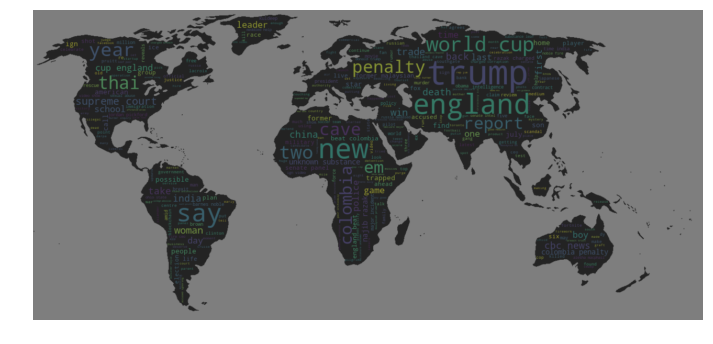

In [11]:
world_map_outline_mask = "./world-map-outline.png"
generateWordCloud(generateCleanWordsFromTitles(world_headlines_df['title']), 
                 plot_title = "World Headlines - Top Words", 
                 filenameToSave = 'World-WordCloud',
                 mask_image = world_map_outline_mask
                )

## Top Words from US Headlines

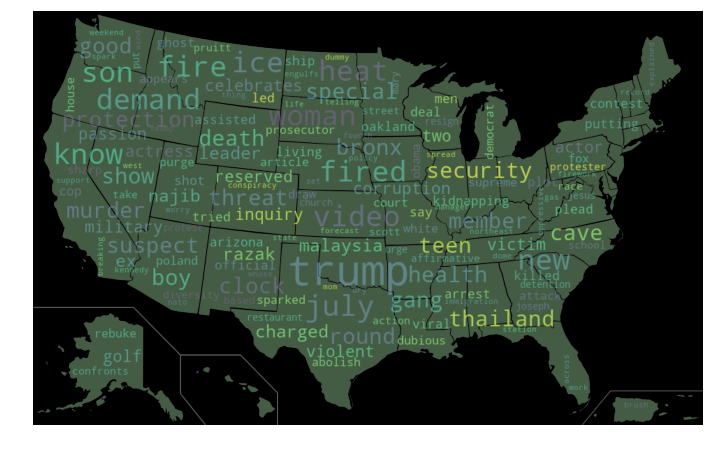

In [12]:
us_map_outline_mask = "./us-map-outline.png"
generateWordCloud(generateCleanWordsFromTitles(us_headlines_df['title']), 
                 plot_title = "US Headlines - Top Words", 
                 filenameToSave = 'US-WordCloud',
                 mask_image = us_map_outline_mask
                )

## Find the top 10 words in the world media today
## Generate word frequency

## Find the top 10 words in the US media today
## Generate word frequency

In [13]:
def generateWordFrequency(text_as_strings):
    #print(text_as_strings)
    tokens = text_as_strings.split(" ")
    
    freq = {}

    for i in tokens:
        
        if i in freq:
            freq[i] += 1
        else:
            freq[i] = 1
    
    return freq
    
#print(freq)

In [14]:
#generateCleanWordsFromTitles(world_headlines_df['title'])

## World Media Top Words

In [15]:
#generateWordFrequency(world_headline_words)
w_wf = generateWordFrequency(generateCleanWordsFromTitles(world_headlines_df['title']))

In [16]:
FreqDist.most_common(w_wf)[:20]

[('trump', 51),
 ('england', 45),
 ('the', 28),
 ('colombia', 26),
 ('say', 25),
 ('world', 23),
 ('penalty', 23),
 ('news', 21),
 ('cup', 19),
 ('new', 19),
 ('two', 18),
 ('cave', 16),
 ('2018', 16),
 ('video', 15),
 ('court', 14),
 ('india', 14),
 ('former', 14),
 ('senate', 13),
 ('thai', 13),
 ('charged', 13)]

## US Media Top Words

In [17]:
us_wf = generateWordFrequency(generateCleanWordsFromTitles(us_headlines_df['title']))

In [18]:
FreqDist.most_common(us_wf)[:20]

[('trump', 5),
 ('video', 2),
 ('woman', 2),
 ('son', 2),
 ('fire', 2),
 ('demand', 2),
 ('know', 2),
 ('july', 2),
 ('heat', 2),
 ('there', 2),
 ('fired', 2),
 ('', 1),
 ('after', 1),
 ('death', 1),
 ('threat', 1),
 ('gang', 1),
 ('member', 1),
 ('suspect', 1),
 ('bronx', 1),
 ('teen', 1)]

## Getting Sentiment Analysis for Headlines 
**Sentiment Analysis** <br/>
*Using vaderSentiment Analyzer to analize the new media sentiment from the headline*

### getSentiments Method
### Input: Dataframe returned by getCurrentHeadlines() call
### Return: sentiment list
#### Sentiment parameters
    "Headlines", 
    "Channel",
    "Compound",
    "Positive",
    "Negative",
    "Neutral"

In [19]:
def getSentiments(df):
    sentiments = []

    for index, row in df.iterrows():

        words = preprocessing(row['title'])

        # Run Vader Analysis on each headline
        results = analyzer.polarity_scores(words)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add sentiments for each tweet into a list
        sentiments.append({"Headlines": row['title'], 
                           "Channel": row['News Channel'],
                           "Compound": compound,
                           "Positive": pos,
                           "Negative": neu,
                           "Neutral": neg})
        
    return sentiments

## Sentiment Analysis from World Headlines

In [20]:
world_sentiment_df = pd.DataFrame(getSentiments(world_headlines_df[:20]))

In [21]:
world_sentiment_df

,Channel,Compound,Headlines,Negative,Neutral,Positive
0,The Sport Bible,0.4215,From Gangs To Goals: How Football Saved Englan...,0.763,0.000,0.237
1,The Jerusalem Post,-0.5574,Palestinian Authority: We'll continue to pay p...,0.392,0.480,0.127
2,The Jerusalem Post,0.0000,Israel Post to be privatized. But what about t...,1.000,0.000,0.000
3,Fox News,0.0000,Suzanne Somers reflects on her legendary career,1.000,0.000,0.000
4,The Hindu,0.6369,Supreme Court to deliver verdict on Centre-Del...,0.435,0.000,0.565
5,Fox News,0.0000,Who is Brett Kavanaugh?,1.000,0.000,0.000
6,Fox News,-0.4404,Coney Barrett facing criticism from Dems over ...,0.633,0.367,0.000
7,The Times of India,0.0000,"The Times of India: Latest News India, World &...",1.000,0.000,0.000
8,Fox News,0.0772,American pride and patriotism at an all time low?,0.400,0.280,0.320
9,Financial Times,0.0000,Senate panel backs finding of Russian meddling...,1.000,0.000,0.000


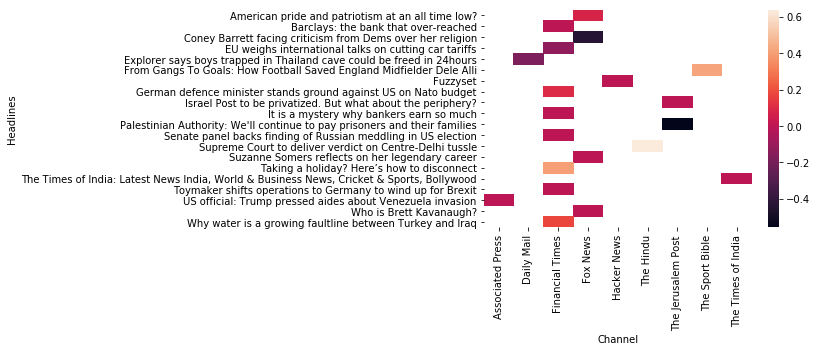

In [22]:
world_sentiment_heatmap = world_sentiment_df.pivot_table(values='Compound',index='Headlines',columns='Channel')
world_sentiment_hp_fig = sns.heatmap(world_sentiment_heatmap)
world_sentiment_hp_fig.get_figure().savefig("World-Sentiment-HeatMap.png", bbox_inches = "tight")

## Sentiment Analysis from US Headlines

In [23]:
us_sentiment_df = pd.DataFrame(getSentiments(us_headlines_df))
us_sentiment_df

,Channel,Compound,Headlines,Negative,Neutral,Positive
0,Nydailynews.com,-0.8779,"After death threats, gang member suspects in B...",0.293,0.520,0.187
1,Bbc.com,0.4404,Thailand cave: New video shows boys in good he...,0.707,0.000,0.293
2,The New York Times,-0.2023,"Malaysia's Ex-Leader, Najib Razak, Is Charged ...",0.769,0.231,0.000
3,The New York Times,0.7717,Reserved Trump Celebrates Two Passions: Milita...,0.427,0.000,0.573
4,Nydailynews.com,-0.8126,Actress and actor were victims in violent kidn...,0.488,0.512,0.000
5,Fox News,-0.6705,"Arizona woman, 92, shot, killed son who tried ...",0.690,0.310,0.000
6,Sfgate.com,-0.5719,Oakland Ghost Ship fire: Men plead no contest ...,0.598,0.402,0.000
7,CNN,-0.6808,Dubious Fox News article appears to have spark...,0.556,0.444,0.000
8,The Washington Post,-0.1280,'Abolish ICE' demands from Democrats draw shar...,0.842,0.158,0.000
9,The New York Times,0.5574,"Poland Purges Supreme Court, and Protesters Ta...",0.625,0.000,0.375


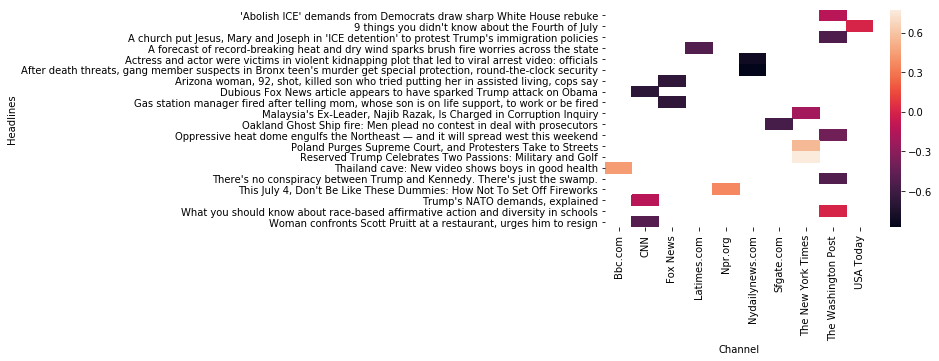

In [24]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
us_sentiment_heatmap = us_sentiment_df.pivot_table(values='Compound',index='Headlines',columns='Channel')
us_sentiment_hp_fig = sns.heatmap(us_sentiment_heatmap)
us_sentiment_hp_fig.get_figure().savefig("US-Sentiment-HeatMap.png", bbox_inches = "tight")